# Data

- [Download corrupted Cifar10 .tar](https://zenodo.org/records/2535967) and extract it into a folder.

- Cifar10 is downloaded using torch.datasets

- [Download corrupted Tiny-ImageNet](https://zenodo.org/records/2536630) and extract it into a folder.

- [Download Tiny-ImageNet](https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet) and extract it into a folder.

# 1) Imports


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
import os

from utils import load_CIFAR10
from transformers import DistilledVisionTransformer

# 2) Loading Data

In [2]:
# config device
device = "cuda" if torch.cuda.is_available() else "cpu"

# load corrupted data and corresponding labels
normal_data_root, corrupt_data_path = "./CIFAR-10-NORMAL", "./CIFAR-10-C"
corrupt_types = ["motion_blur"]
means, stds = torch.tensor([0.4914, 0.4822, 0.4465]), torch.tensor([0.247, 0.243, 0.261])
transform = T.Compose([T.ToTensor(), T.Normalize(means, stds)])

normal_data, corrupt_data = load_CIFAR10(
    normal_data_root, corrupt_data_path, transform,
    corrupt_types=corrupt_types, device=device
    )

# Visualizing Data

- Visualizing Normal Images from CIFAR-10

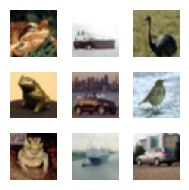

In [3]:
imgs_to_display = [random.randint(0, len(normal_data['train'])-1) for i in range(9)]
fig, axes = plt.subplots(3, 3, figsize=(2, 2))
axes = axes.flatten()
inv_normalize = T.Normalize(
    mean=[-m/s for m, s in zip((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))],
    std=[1/s for s in (0.247, 0.243, 0.261)]
)
for i in range(9):
    img, label = normal_data['train'][imgs_to_display[i]]
    img = inv_normalize(img).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

- Visualizing Corrupted Images from CIFAR-10

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

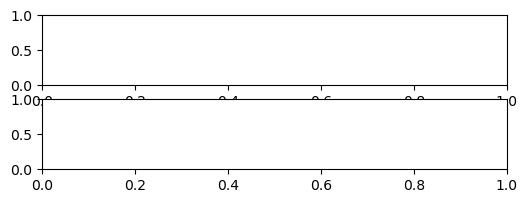

In [4]:
imgs_to_display = [random.randint(0, len(corrupt_data['labels'])-1) for i in range(2)]
fig, axes = plt.subplots(len(imgs_to_display), len(corrupt_data)-1, figsize=(6, 2))

for i in range(len(axes)):
    j = 0
    for key in corrupt_data:
        if key == "labels": continue
        # inverse transformation for plotting
        img = corrupt_data[key][imgs_to_display[i]] * stds.view(3, 1, 1) + means.view(3, 1, 1)
        img = img.permute(1, 2, 0).numpy()
        axes[i][j].imshow(img)
        axes[i][j].axis("off")
        if i == 0:
            axes[i][j].set_title(key, fontsize=8)
        j+=1

plt.tight_layout()
plt.show()

# Model

In [ ]:
# setting seed 
torch.cuda.manual_seed(22)
random.seed(22)
torch.manual_seed(22)

# Hyper-parameters
BATCH_SIZE = 128
PATCH_SIZE = 4
IMG_SIZE = 32
EMBED_DIM = 256
NUM_HEADS = 2
NUM_ENCODERS = 2
NUM_CLASSES = 10
DROPOUT = 0.1

train_loader = DataLoader(dataset=normal_data['train'], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=normal_data['test'], batch_size=BATCH_SIZE, shuffle=False)

tiny_vit_model = DistilledVisionTransformer(
    EMBED_DIM, IMG_SIZE, PATCH_SIZE, NUM_CLASSES, 
    attention_heads=NUM_HEADS, num_encoders=NUM_ENCODERS, dropout=DROPOUT
    ).to(device)

3


In [279]:
from torchvision import datasets

def load_experimental_TinyImageNet(
        normal_data_path: str,
        corrupt_data_path: str, 
        corrupt_types=["motion_blur"],
        num_train_imgs=40,
        num_test_imgs=4,
    ):
    """ 
    Returns transformed normal and corrupted Tiny ImageNet mixed and shuffled together. 
    It is better to save the data after execution.
    Args:
        normal_data_path (str): Path where normal Tiny ImageNet is saved.
        corrupt_data_path (str): Path of the directory containing folders of Tiny ImageNet corruptions.
        corrupt_types (tuple or list): Sequence of corruption types to load from corrupted Tiny ImageNet
            (matching to the folder names). Defaults to ["motion_blur"].
        device: cpu or cuda. Defaults to "cpu".
    Returns:
        train and test experiment data. Each is a tuple of tensors: (images, labels, corruption type)
    """
    mean = (0.4802, 0.4481, 0.3975)
    std = (0.2302, 0.2265, 0.2262)
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std)
    ])

    class_names = sorted(os.listdir(os.path.join(normal_data_path, "train")))
    label_map = {cls: i for i, cls in enumerate(class_names)}
    corruption_map = {c: i for i, c in enumerate(corrupt_types)}
    corruption_map["normal"] = len(corrupt_types)

    train_imgs, test_imgs = [], []
    train_labels, test_labels = [], []
    train_corrupts, test_corrupts = [], []

    # collect corrupted data
    if len(corrupt_types) != 0:
        for corrupt_type in corrupt_types:
            for severity in range(1, 6):
                path = os.path.join(corrupt_data_path, corrupt_type, str(severity))
                dataset = datasets.ImageFolder(root=path, transform=transform)
                loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

                # Load all data in one go
                imgs, labels = next(iter(loader))

                # Split train/test
                imgs_per_class = {i: [] for i in range(len(class_names))}
                for img, label in zip(imgs, labels):
                    class_name = dataset.classes[label]
                    true_label = label_map[class_name]
                    imgs_per_class[true_label].append(img)

                for true_label in imgs_per_class:
                    imgs_list = imgs_per_class[true_label]
                    train_imgs.extend(imgs_list[:num_train_imgs])
                    test_imgs.extend(imgs_list[num_train_imgs:num_train_imgs+num_test_imgs])

                    train_labels.append(torch.full((num_train_imgs,), true_label))
                    test_labels.append(torch.full((num_test_imgs,), true_label))

                    train_corrupts.append(torch.full((num_train_imgs,), corruption_map[corrupt_type]))
                    test_corrupts.append(torch.full((num_test_imgs,), corruption_map[corrupt_type]))

    # collect normal data
    for cls in class_names:
        img_path = os.path.join(normal_data_path, "train", cls, "images")
        img_files = os.listdir(img_path)
        train_imgs.extend([
            transform(Image.open(os.path.join(img_path, f)).convert("RGB")) for f in img_files[:num_train_imgs*5]
            ])
        test_imgs.extend([
            transform(Image.open(os.path.join(img_path, f)).convert("RGB")) for f in img_files[num_train_imgs*5:(num_train_imgs*5)+(num_test_imgs*5)]
            ])
        
        train_labels.append(torch.full((num_train_imgs*5,), label_map[cls]))
        test_labels.append(torch.full((num_test_imgs*5,), label_map[cls]))

    train_corrupts.append(torch.full((num_train_imgs*5*len(class_names),), corruption_map["normal"]))
    test_corrupts.append(torch.full((num_test_imgs*5*len(class_names),), corruption_map["normal"]))

    # organize data
    train_data = (torch.stack(train_imgs), torch.cat(train_labels), torch.cat(train_corrupts))
    test_data = (torch.stack(test_imgs), torch.cat(test_labels), torch.cat(test_corrupts))

    # shuffling
    perm = torch.randperm(train_data[0].size(0))
    train_data = (train_data[0][perm],train_data[1][perm],train_data[2][perm])
    perm = torch.randperm(test_data[0].size(0))
    test_data = (test_data[0][perm],test_data[1][perm],test_data[2][perm])

    return train_data, test_data

In [ ]:
corrupt_path = r"C:\Users\Hp\Desktop\Coding\Transformer-Thesis\Tiny-ImageNet-C\Tiny-ImageNet-C"
normal_path = r"C:\Users\Hp\Desktop\Coding\Transformer-Thesis\Tiny-ImageNet-Normal"

corrupt_types = ["motion_blur", "jpeg_compression", "defocus_blur", "fog"]
device = "cuda" if torch.cuda.is_available() else "cpu"

train_data, test_data = load_experimental_TinyImageNet(normal_path, corrupt_path, corrupt_types, device=device)

In [ ]:
torch.save(train_data, "experiment_train_data.pt")
torch.save(test_data, "experiment_test_data.pt")

{0, 1, 2, 3, 4}